Loading dataset...
✅ Loaded 100000 rows and 20 columns

Running feature engineering...
✅ Added numeric Date feature (days since start)

Training: 80000 rows | Testing: 20000 rows

Training Random Forest...

📊 Random Forest Performance:
MAE : 17.15
RMSE : 27.93
R² : 0.8508
✅ Approx. Accuracy: 85.08%


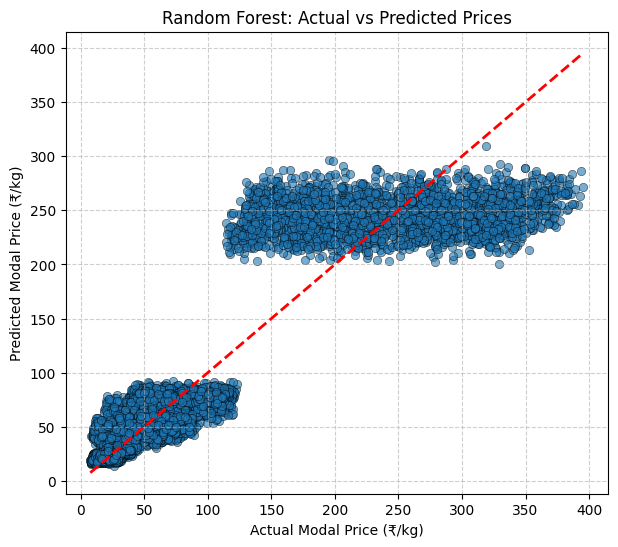

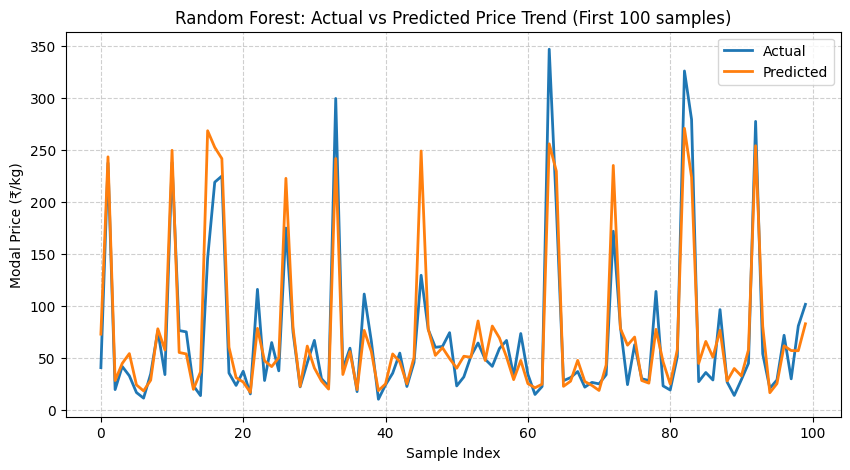


Training XGBoost...

📊 XGBoost Performance:
MAE : 17.37
RMSE : 28.54
R² : 0.8442
✅ Approx. Accuracy: 84.42%


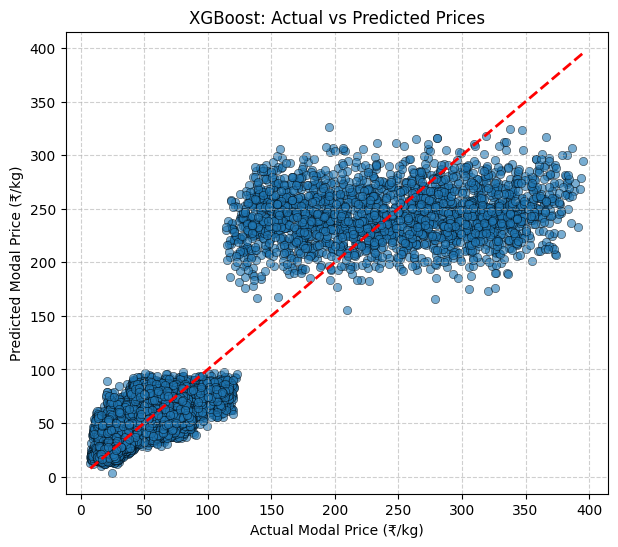

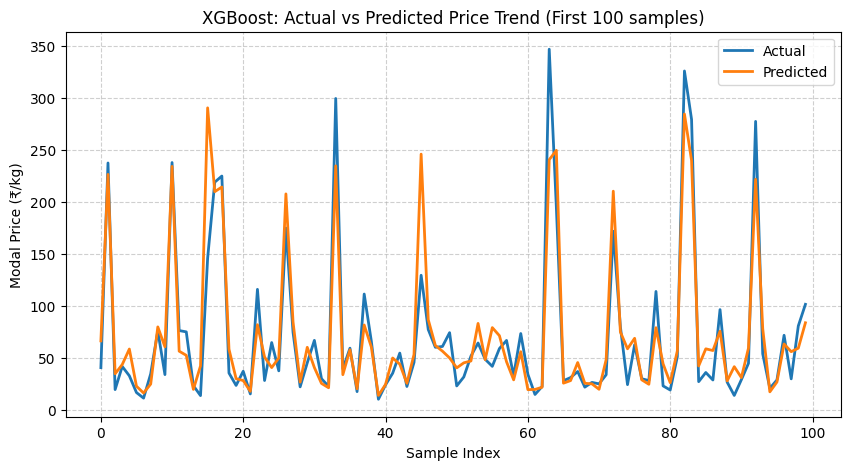


🌿 Model Comparison Summary
Random Forest R²: 0.8508
XGBoost R²       : 0.8442
Better Model     : Random Forest

💾 Model saved as 'crop_price_prediction_model_v6_date.pkl'
🎯 Training and Comparison Complete!


In [2]:
# =====================================================
# 🌾 Crop Price Prediction - Model Testing Notebook
# =====================================================
# RandomForest vs XGBoost 
# =====================================================

import pandas as pd
import numpy as np
import joblib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# Optional: XGBoost
try:
    from xgboost import XGBRegressor
    xgb_available = True
except ImportError:
    xgb_available = False

warnings.filterwarnings("ignore")

# =====================================================
# 1️⃣ Load Dataset
# =====================================================
def load_dataset(path):
    print("Loading dataset...")
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    print(f"✅ Loaded {len(df)} rows and {len(df.columns)} columns")
    return df

# =====================================================
# 2️⃣ Feature Engineering
# =====================================================
def feature_engineering(df):
    print("\nRunning feature engineering...")
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    
    # Convert date to numeric timestamp (days since start)
    df["DateNumeric"] = (df["Date"] - df["Date"].min()).dt.days

    df.fillna(method="ffill", inplace=True)
    print("✅ Added numeric Date feature (days since start)")
    return df

# =====================================================
# 3️⃣ Define Features & Target
# =====================================================
def get_feature_target(df):
    features = [
        "Crop", "Market", "AgroZone", "Season",
        "Rainfall(mm)", "AvgTemperature(°C)", "Humidity(%)", "SoilMoisture(%)",
        "DemandIndex", "Supply(quintals)", "FuelPriceIndex", "InflationRate(%)",
        "CommodityTrendIndex", "DateNumeric"
    ]
    target = "ModalPrice"
    return df[features], df[target]

# =====================================================
# 4️⃣ Build Pipeline (Preprocessing + Model)
# =====================================================
def build_pipeline(model_name="rf"):
    categorical_features = ["Crop", "Market", "AgroZone", "Season"]
    numeric_features = [
        "Rainfall(mm)", "AvgTemperature(°C)", "Humidity(%)", "SoilMoisture(%)",
        "DemandIndex", "Supply(quintals)", "FuelPriceIndex", "InflationRate(%)",
        "CommodityTrendIndex", "DateNumeric"
    ]

    # ✅ Version-safe OneHotEncoder (works for all sklearn versions)
    import inspect
    if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
        onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    else:
        onehot = OneHotEncoder(handle_unknown="ignore", sparse=False)

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", onehot)
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

    # Model choice
    if model_name == "rf":
        model = RandomForestRegressor(
            n_estimators=250, max_depth=25, n_jobs=-1, random_state=42
        )
    elif model_name == "xgb" and xgb_available:
        model = XGBRegressor(
            n_estimators=400, learning_rate=0.08, max_depth=10,
            subsample=0.9, colsample_bytree=0.8, random_state=42
        )
    else:
        raise ValueError("Model name must be 'rf' or 'xgb' (and xgboost installed).")

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    return pipeline


  

# =====================================================
# 5️⃣ Evaluate Model (Scatter + Line)
# =====================================================
def evaluate_model(model, X_test, y_test, name="Model"):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    print(f"\n📊 {name} Performance:")
    print(f"MAE : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R² : {r2:.4f}")
    print(f"✅ Approx. Accuracy: {r2*100:.2f}%")

    # === Scatter Plot (Actual vs Predicted) ===
    plt.figure(figsize=(7,6))
    sns.scatterplot(x=y_test, y=preds, alpha=0.6, edgecolor="k")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
    plt.title(f"{name}: Actual vs Predicted Prices")
    plt.xlabel("Actual Modal Price (₹/kg)")
    plt.ylabel("Predicted Modal Price (₹/kg)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    # === Line Comparison ===
    compare_df = pd.DataFrame({
        "Actual": y_test.values,
        "Predicted": preds
    }).reset_index(drop=True)

    plt.figure(figsize=(10,5))
    plt.plot(compare_df.index[:100], compare_df["Actual"][:100], label="Actual", lw=2)
    plt.plot(compare_df.index[:100], compare_df["Predicted"][:100], label="Predicted", lw=2)
    plt.title(f"{name}: Actual vs Predicted Price Trend (First 100 samples)")
    plt.xlabel("Sample Index")
    plt.ylabel("Modal Price (₹/kg)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# =====================================================
# 6️⃣ Model Comparison + Saving Best Model
# =====================================================
def main():
    df = load_dataset("dataset refined/westbengal_crop_price_dataset_v6.csv")
    df = feature_engineering(df)
    X, y = get_feature_target(df)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"\nTraining: {len(X_train)} rows | Testing: {len(X_test)} rows")

    print("\nTraining Random Forest...")
    rf_model = build_pipeline("rf")
    rf_model.fit(X_train, y_train)
    rf_metrics = evaluate_model(rf_model, X_test, y_test, "Random Forest")

    if xgb_available:
        print("\nTraining XGBoost...")
        xgb_model = build_pipeline("xgb")
        xgb_model.fit(X_train, y_train)
        xgb_metrics = evaluate_model(xgb_model, X_test, y_test, "XGBoost")

        print("\n============================")
        print("🌿 Model Comparison Summary")
        print("============================")
        print(f"Random Forest R²: {rf_metrics['R2']:.4f}")
        print(f"XGBoost R²       : {xgb_metrics['R2']:.4f}")
        print(f"Better Model     : {'XGBoost' if xgb_metrics['R2']>rf_metrics['R2'] else 'Random Forest'}")

        best_model = xgb_model if xgb_metrics["R2"] > rf_metrics["R2"] else rf_model
    else:
        best_model = rf_model

    joblib.dump(best_model, "crop_price_prediction_model_v6_date.pkl")
    print("\n💾 Model saved as 'crop_price_prediction_model_v6_date.pkl'")
    print("🎯 Training and Comparison Complete!")

if __name__ == "__main__":
    main()
